In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt  # For making charts
import seaborn as sns 
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Dataset Overview

In [5]:
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (891, 12)
Test set shape: (418, 11)


In [6]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [7]:
print(train_df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [8]:
print("\n❓ Missing data check:")
missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0])


❓ Missing data check:
Age         177
Cabin       687
Embarked      2
dtype: int64


# Survival by Gender Analysis

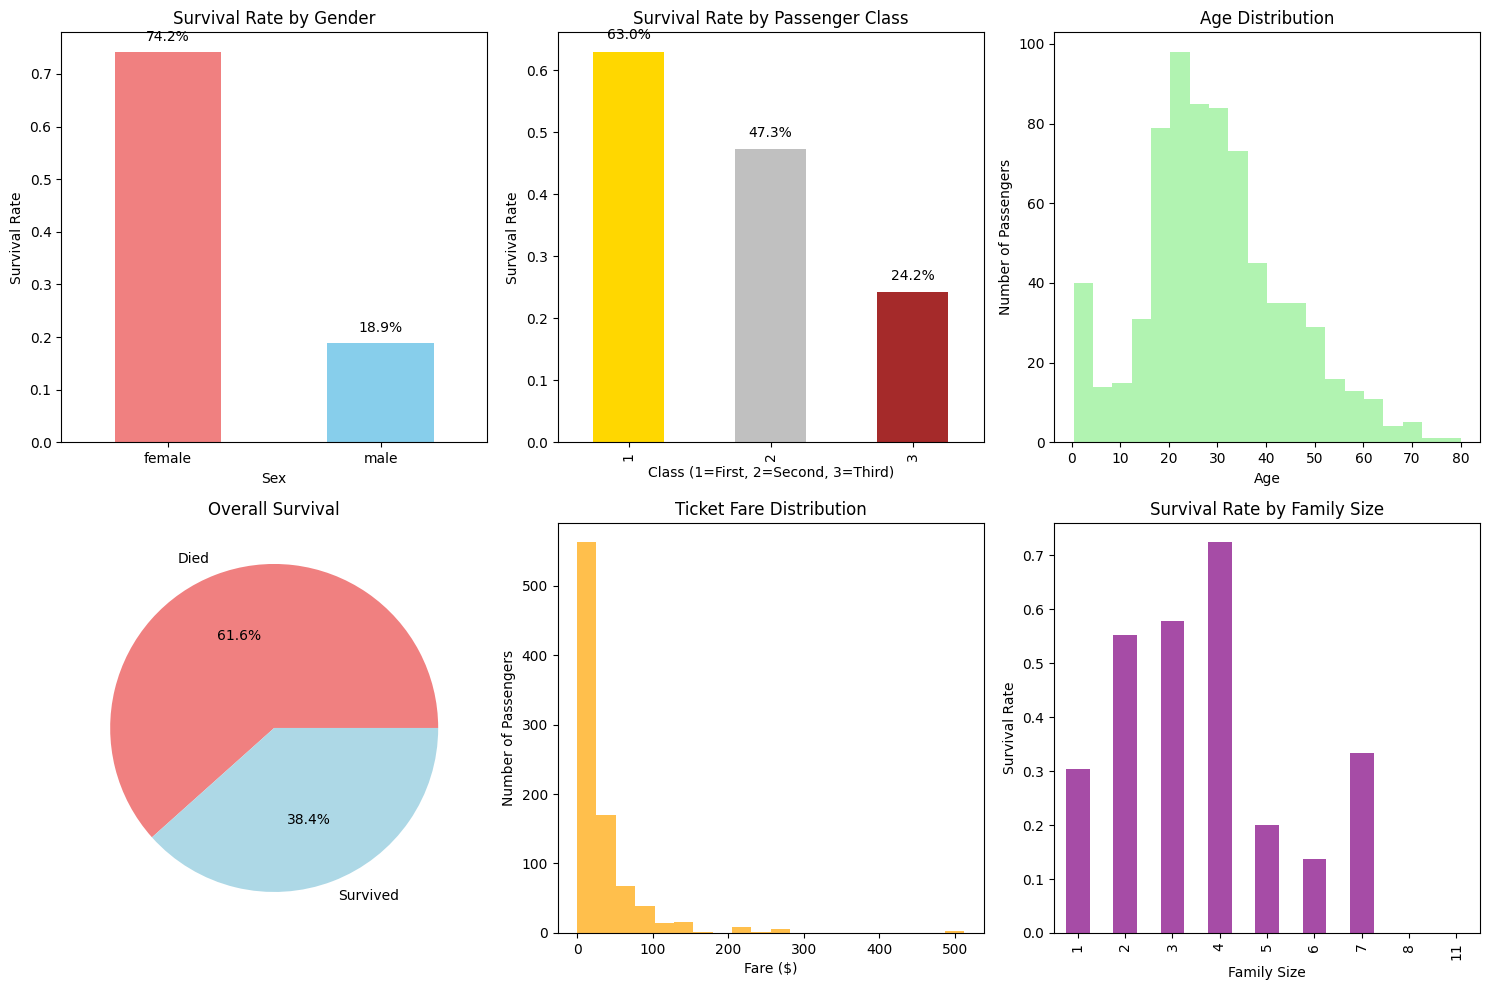

In [9]:
plt.figure(figsize=(15, 10))

# Chart 1: Survival by gender
plt.subplot(2, 3, 1)
survival_by_sex = train_df.groupby('Sex')['Survived'].mean()
survival_by_sex.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Survival Rate by Gender')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)

# Add percentages on bars
for i, v in enumerate(survival_by_sex):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center')

# Chart 2: Survival by class
plt.subplot(2, 3, 2)
survival_by_class = train_df.groupby('Pclass')['Survived'].mean()
survival_by_class.plot(kind='bar', color=['gold', 'silver', 'brown'])
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.xlabel('Class (1=First, 2=Second, 3=Third)')

# Add percentages on bars
for i, v in enumerate(survival_by_class):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center')

# Chart 3: Age distribution
plt.subplot(2, 3, 3)
plt.hist(train_df['Age'].dropna(), bins=20, alpha=0.7, color='lightgreen')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')

# Chart 4: Simple survival pie chart
plt.subplot(2, 3, 4)
survival_counts = train_df['Survived'].value_counts()
plt.pie(survival_counts, labels=['Died', 'Survived'], autopct='%1.1f%%', 
        colors=['lightcoral', 'lightblue'])
plt.title('Overall Survival')

# Chart 5: Fare distribution
plt.subplot(2, 3, 5)
plt.hist(train_df['Fare'].dropna(), bins=20, alpha=0.7, color='orange')
plt.title('Ticket Fare Distribution')
plt.xlabel('Fare ($)')
plt.ylabel('Number of Passengers')

# Chart 6: Family size effect
plt.subplot(2, 3, 6)
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
family_survival = train_df.groupby('FamilySize')['Survived'].mean()
family_survival.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')

plt.tight_layout()
plt.show()